In [1]:
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import os
import open_clip
from PIL import Image
from torch import nn
from generation_utils.train_mydisenbooth import DisenBoothAdapter
import argparse
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from pathlib import Path
import argparse
import shlex


model_id = "stabilityai/stable-diffusion-2-1-base"
pipe1 = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")
pipe2 = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")
with torch.no_grad():
    img_model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
    img_model = img_model.to("cuda")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes-0.38.1-py3.10.egg/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-11.7/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes-0.38.1-py3.10.egg/bitsandbytes/libbitsandbytes_cuda117.so...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
class Image_adapter(nn.Module):
    def __init__(self, hidden_size=1024):
        super().__init__()
        self.adapter = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.mask = nn.Parameter(torch.zeros(hidden_size))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, feature, do_mask=True):
        if do_mask:
            out_feature = self.adapter( self.sigmoid(self.mask)*feature ) + self.sigmoid(self.mask)*feature
        else:
            out_feature = self.adapter(feature ) + feature
            
        return out_feature   

In [3]:
def disenbooth_infer(pipe, img_model, adapter=None, prompt = None, reference_image=None ,text_weight=1.0, image_weight=0.0, 
                    height = 512, width = 512, num_inference_steps = 50, guidance_scale= 7.0, negative_prompt = None, 
                    num_images_per_prompt = 1, eta = 0.0, generator = None, latents = None, prompt_embeds = None, 
                    negative_prompt_embeds = None, output_type = "pil", return_dict = True, cross_attention_kwargs = None, 
                    guidance_rescale: float = 0.0, clip_skip=None, do_mask=True):
    with torch.no_grad():
        height = height or pipe.unet.config.sample_size * pipe.vae_scale_factor
        width = width or pipe.unet.config.sample_size * pipe.vae_scale_factor
        # to deal with lora scaling and other possible forward hooks
    
        # 1. Check inputs. Raise error if not correct
    
        pipe._guidance_scale = guidance_scale
        pipe._guidance_rescale = guidance_rescale
        pipe._cross_attention_kwargs = cross_attention_kwargs
        pipe._clip_skip = clip_skip

        img_feature = img_model.encode_image( reference_image).unsqueeze(1) 
        if adapter is not None:
            img_feature = adapter(img_feature, do_mask=do_mask)
    
        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
    
        device = pipe._execution_device
        lora_scale = (pipe.cross_attention_kwargs.get("scale", None) if pipe.cross_attention_kwargs is not None else None)
    
        prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            pipe.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=pipe.clip_skip,
        )
        if pipe.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
            img_feature = torch.cat([torch.zeros_like(img_feature),img_feature])
        prompt_embeds = text_weight*prompt_embeds + image_weight*img_feature
        
        # 4. Prepare timesteps
        pipe.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = pipe.scheduler.timesteps
    
        # 5. Prepare latent variables
        num_channels_latents = pipe.unet.config.in_channels
        latents = pipe.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )
    
        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    
        # 6.5 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if pipe.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(pipe.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = pipe.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=pipe.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)
    
        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
        pipe._num_timesteps = len(timesteps)
        with pipe.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if pipe.do_classifier_free_guidance else latents
                latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
                # predict the noise residual
                noise_pred = pipe.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=pipe.cross_attention_kwargs,
                    return_dict=False,
                )[0]
    
                # perform guidance
                if pipe.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + pipe.guidance_scale * (noise_pred_text - noise_pred_uncond)
    
                if pipe.do_classifier_free_guidance and pipe.guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=pipe.guidance_rescale)
                # compute the previous noisy sample x_t -> x_t-1
                latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                    progress_bar.update()
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[0]
        if torch.is_tensor(image):
            feature_extractor_input = pipe.image_processor.postprocess(image, output_type="pil")
        else:
            feature_extractor_input = pipe.image_processor.numpy_to_pil(image)
        image = feature_extractor_input
    return image

In [4]:
def get_images(ref_path, prompt, pipe, adapter):
    torch.manual_seed(1)
    ref_im = Image.open(ref_path)
    print('ref_path', ref_path)
    ref_image = preprocess(ref_im).unsqueeze(0).to("cuda")
    '''
    identity_irrel = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt="", 
                                      text_weight=0.0, image_weight=1.0)[0]
    prompt_plus_irrel = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt=prompt, 
                                    text_weight=1.0, image_weight=1.0)[0]
    '''
    identity_irrel_nomask = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt="", 
                                      text_weight=0.0, image_weight=1.0, do_mask=False)[0]
    prompt_plus_irrel_nomask = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt=prompt, 
                                    text_weight=1.0, image_weight=1.0, do_mask=False)[0]
    # return ref_im, identity_irrel, identity_irrel_nomask, prompt_plus_irrel, prompt_plus_irrel_nomask
    return ref_im, identity_irrel_nomask, prompt_plus_irrel_nomask

## Table Generation

In [5]:
subject = 'backpack_dog'
lora_path1 = f"checkpoints/disenbooth-nomask/{subject}/sd2.1/checkpoint-1800"
lora_path2 = f"checkpoints/mydisenbooth/{subject}/sd2.1"
pipe1.load_lora_weights(lora_path1)
pipe2.load_lora_weights(lora_path2)
adapter1 = Image_adapter().to("cuda")
adapter2 = DisenBoothAdapter().to("cuda")
adapter1.load_state_dict(torch.load(os.path.join(lora_path1, "adapter.pt")))
adapter2.load_state_dict(torch.load(os.path.join(lora_path2, "adapter.pt")))

<All keys matched successfully>

In [6]:
data_path = 'datasets/dreambooth'

# dog

if subject == 'dog':
    ref_prompt_pairs = [
        (f"{data_path}/dog/00.jpg", "a cute kitten"),
        (f"{data_path}/dog/01.jpg", "a joyful boy"),
        (f"{data_path}/dog/03.jpg", "a dwarf elephant"),
        (f"{data_path}/dog/02.jpg", "a white cat"),
        (f"{data_path}/dog/04.jpg", "a white cat"),
        (f"{data_path}/dog7/00.jpg", "a white cat")
    ]
elif subject == 'can':
    ref_prompt_pairs = [
        (f"{data_path}/can/00.jpg", "a cute kitten"),
        (f"{data_path}/can/01.jpg", "a joyful boy"),
        (f"{data_path}/can/03.jpg", "a dwarf elephant"),
        (f"{data_path}/can/02.jpg", "a white cat"),
        (f"{data_path}/can/04.jpg", "a white cat"),
        (f"{data_path}/dog7/00.jpg", "a white cat")
    ]
else:
    ref_prompt_pairs = [
        (f"{data_path}/backpack_dog/00.jpg", "a cute kitten"),
        (f"{data_path}/backpack_dog/01.jpg", "a joyful boy"),
        (f"{data_path}/backpack_dog/03.jpg", "a dwarf elephant"),
        (f"{data_path}/backpack_dog/02.jpg", "a white cat"),
        (f"{data_path}/backpack_dog/04.jpg", "a white cat"),
    #    (f"{data_path}/backpack/00.jpg", "a white cat")
    ]


In [7]:
table = []
for i in range(len(ref_prompt_pairs)):
    ref_im, identity_irrel_nomask, prompt_plus_irrel_nomask = get_images(ref_prompt_pairs[i][0], 
                                                                            ref_prompt_pairs[i][1],
                                                                            pipe1,
                                                                            adapter=adapter1)
    # table.append((ref_im, identity_irrel, identity_irrel_nomask, prompt_plus_irrel, prompt_plus_irrel_nomask))
    table.append((ref_im, identity_irrel_nomask, prompt_plus_irrel_nomask))

ref_path datasets/dreambooth/backpack_dog/00.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

ref_path datasets/dreambooth/backpack_dog/01.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

ref_path datasets/dreambooth/backpack_dog/03.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

ref_path datasets/dreambooth/backpack_dog/02.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

ref_path datasets/dreambooth/backpack_dog/04.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
# columns = ['ref','image ref', 'image ref (mask)', 'image ref+prompt', 'image ref+prompt (mask)']
columns = ['ref', 'image ref (mask)', 'image ref+prompt (mask)']
prompts = [ref_prompt_pairs[i][1] for i in range(len(table))]

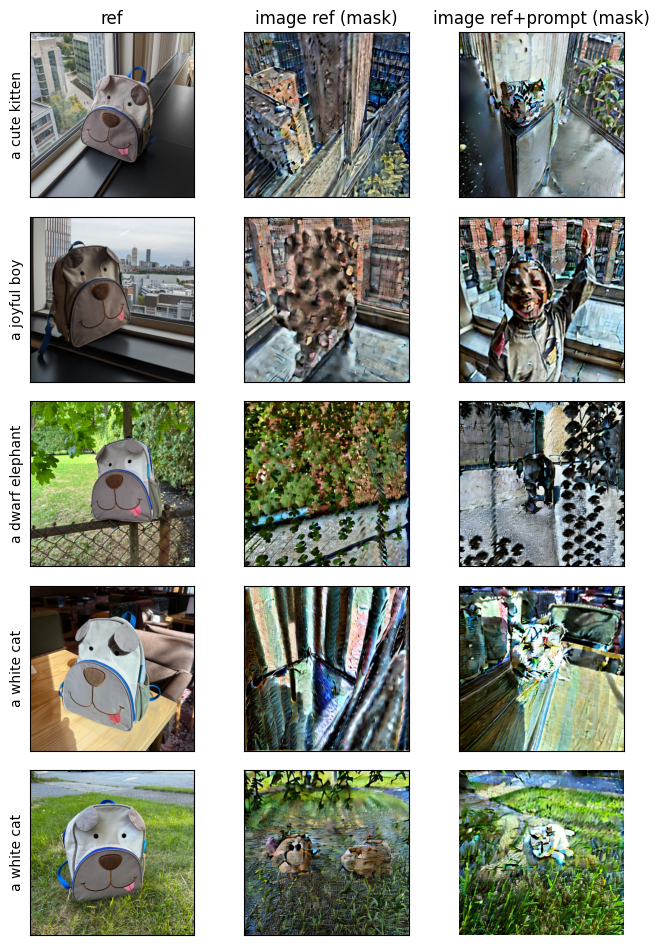

In [9]:
C = len(table[0])
R = len(table)
px = 1/plt.rcParams['figure.dpi']
fig,ax = plt.subplots(R, C)#, figsize=((1 + R) * 512, (1 + C) * 512))
plt.axis('off')

for c in range(C):
    for r in range(R):
        image = table[r][c]
        ax[r][c].imshow(image)

        fig.axes[r * C + c].get_xaxis().set_ticks([])
        fig.axes[r * C + c].get_yaxis().set_ticks([])
        ax[r][c].figure.set_size_inches(C * 3.2, C * 3.2)
        if r == 0:
            ax[r][c].set_title(columns[c])
        if c == 0:
            ax[r][c].set_ylabel(prompts[r]) # f'{r + 1}.' + 

for i in range(4):
    fig.tight_layout()
plt.show()